# imports

In [1]:
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# impute.imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA
# stats : R module
from scipy.stats import skew, kurtosis

# estimators ---------------------------------------
# estimators.classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
# estimators.regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# --------------------------------------------------

# neural network -----------------------------------
import tensorflow as tf
import keras
# --------------------------------------------------

# ensemble -----------------------------------------
# ensemble.bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# ensemble.boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
# ensemble.boosting & bagging
from xgboost import XGBRFClassifier, XGBRFRegressor
# ensemble.voting
from sklearn.ensemble import VotingClassifier, VotingRegressor
# --------------------------------------------------

# metrics ------------------------------------------
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# --------------------------------------------------

# model_selection ----------------------------------
# model_selection.splitter
from sklearn.model_selection import train_test_split
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------

# optuna -------------------------------------------
import optuna
# --------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.core.display import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rcParams['font.family'] = 'Malgun Gothic'

# read

In [3]:
cus   = pd.read_csv('./data/cus_info.csv')
iem   = pd.read_csv('./data/iem_info_20210902.csv')
hist  = pd.read_csv('./data/stk_bnc_hist.csv')
train = pd.read_csv('./data/stk_hld_train.csv')
test  = pd.read_csv('./data/stk_hld_test.csv')
sub   = pd.read_csv('./data/sample_submission.csv')

# EDA

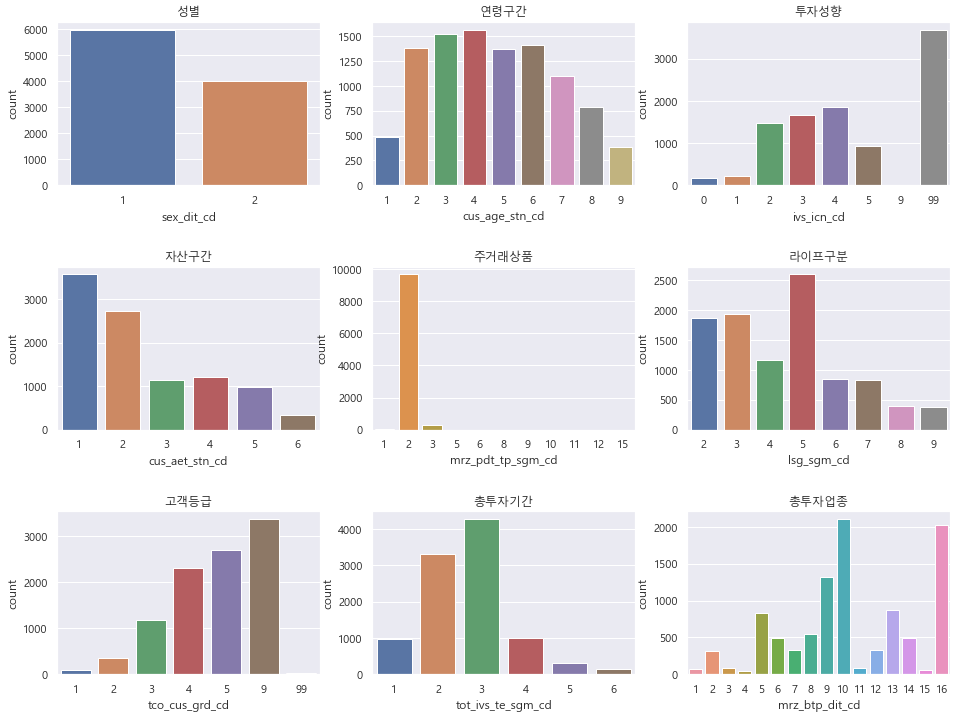

In [4]:
cus_cols = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']
cols     = ['성별', '연령구간', '투자성향', '자산구간', '주거래상품', '라이프구분', '고객등급', '총투자기간', '총투자업종']    

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols):
    r = i // 3
    c = i % 3
    sns.countplot(col, data=cus, ax=ax[r, c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

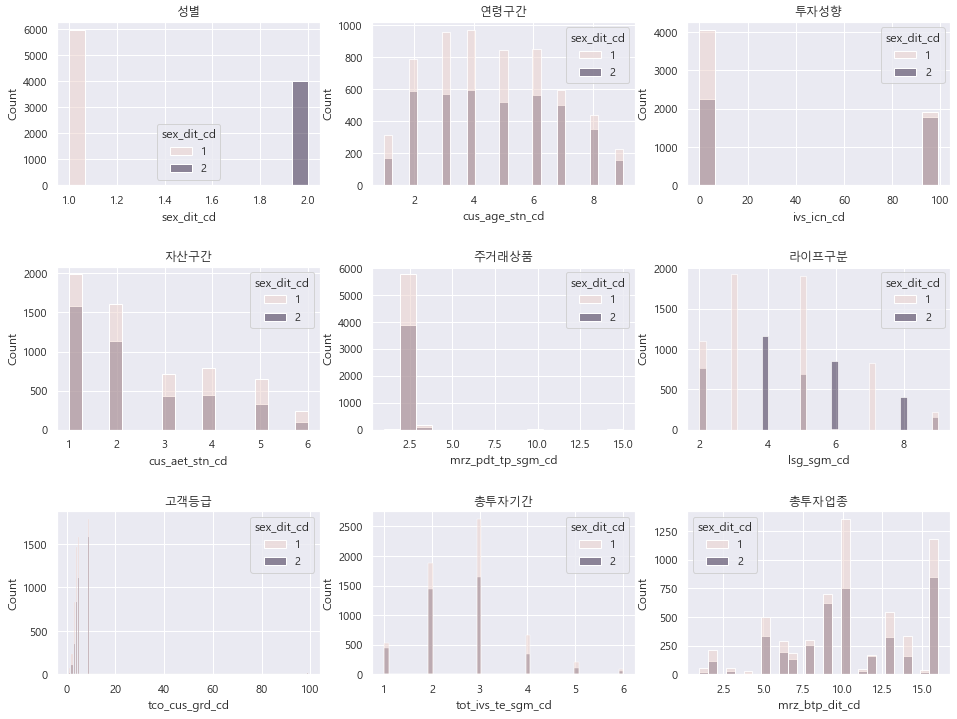

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols) :
    r = i // 3
    c = i % 3
    sns.histplot(data=cus, x=col, hue='sex_dit_cd', ax=ax[r ,c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# feature engineering

## cus.ivs_icn_cd : 투자성향

In [6]:
# 투자성향 미정의(99) 비율 0.3687 : drop
print(cus[cus['ivs_icn_cd'] == 99].shape[0] / cus.shape[0])
cus.drop('ivs_icn_cd', axis=1, inplace=True)

0.3687


In [7]:
# ivs_icn_cd : (거래횟수 / 보유기간)으로 재정의

# train의 hold_d와 test의 hist_d를 합쳐 total_hold 구성
grp_train_test = pd.concat([train[['act_id', 'iem_cd', 'hold_d']], test[['act_id', 'iem_cd', 'hist_d']]]).groupby(by=['act_id', 'iem_cd']).sum()
grp_train_test['total_hold'] = grp_train_test['hold_d'] + grp_train_test['hist_d']

# hist의 계좌/종목별 [거래횟수] 와 train과 test에 있는 계좌/종목별 [보유기간] 합친 dataframe 구성
grp = pd.concat(
    [
        hist.groupby(by=['act_id', 'iem_cd']).count(),
        grp_train_test[['total_hold']],
    ],
    axis=1
)[['bse_dt', 'total_hold']]

# grp['ivs_icn_cd'] : 거래횟수 / 보유기간
grp['ivs_icn_cd'] = grp['bse_dt'] / grp['total_hold'] * 100

# 보유기간이 0인 경우, np.inf를 0으로 대체
grp = grp.replace(np.inf, 0)

# 계좌단위 ivs_icn_cd 평균 : 해당 계좌의 공격적인 성향
grp_mean = grp.groupby('act_id').mean()[['ivs_icn_cd']]

# # cus에 ivs_icn_cd를 merge
cus = cus.merge(grp_mean, how='left', on='act_id')

In [8]:
grp_mean

,ivs_icn_cd
act_id,
0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,25.763585
0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa9b6e6efa399d0bdf31,43.085597
0008d1bfac569bdb998897e2eb8519dec06b9277a686f4c6e06de582c9791b35,41.869049
000a83a961cbcbce40673aed998effbd462fb10dcac8e64c6fa720f2150d3f5a,0.580406
000b92ca83a96312a0909b1f489340f4d399c86555012ffe2c41952ae43dc741,23.252810
...,...
ffea89aa464a4fcf8a5416989d21deef4e748192ba17bf7cf5b79c72a8fd211d,1.415712
ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7bace472b4365f5028535,97.024635
ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae96e7cd290e431aee0a,20.690457


## cus.lsg_sgm_cd : life stage

In [9]:
# 연령과 성별 변수 포함 : drop
cus.drop('lsg_sgm_cd', axis=1, inplace=True)

## cus.tco_cus_grd_cd : 서비스 등급

In [10]:
cus['tco_cus_grd_cd'][cus['tco_cus_grd_cd'] == 99] = 9

<AxesSubplot:>

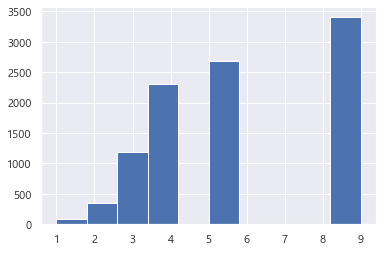

In [11]:
cus['tco_cus_grd_cd'].hist()

## iem.mkt_pr_tal_scl_tp_cd : 시총규모

In [12]:
# 기타(99) -> 3
iem['mkt_pr_tal_scl_tp_cd'][iem['mkt_pr_tal_scl_tp_cd'] == 99] = 3

## iem.stk_dit_cd : 시장구분

In [13]:
# 기타(99) -> 3
iem['stk_dit_cd'][iem['stk_dit_cd'] == 99] = 3

## hist.stk_p : 매매 평균단가

In [14]:
hist['stk_p'] = hist['tot_aet_amt'] / hist['bnc_qty']
hist['stk_p'].fillna(0, inplace=True)

## train.hist_d

In [15]:
train['hist_d'] = train['hold_d'] * 0.7

# merge

## cus & iem

In [16]:
train_data = pd.merge(train, cus, how='left', on='act_id')
train_data = pd.merge(train_data, iem, how='left', on='iem_cd')

test_data = pd.merge(test, cus, how='left', on='act_id')
test_data = pd.merge(test_data, iem, how='left', on='iem_cd')

## hist

In [17]:
train_data = pd.merge(train_data, hist, how='left', on=['act_id', 'iem_cd'])
train_data = train_data[(train_data['byn_dt'] == train_data['bse_dt'])]

test_data = pd.merge(test_data, hist, how = 'left', on=['act_id', 'iem_cd'])
test_data = test_data[(test_data['byn_dt'] == test_data['bse_dt'])]

In [18]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# encode

In [19]:
le = LabelEncoder()
le.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm'] = le.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']  = le.transform(test_data['iem_krl_nm'])

# drop

In [20]:
train_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt'], axis=1, inplace=True)
test_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'submit_id', 'hold_d'], axis=1, inplace=True)

In [21]:
train_data.shape, test_data.shape

((681472, 18), (70596, 17))

## scale

In [22]:
mm = MinMaxScaler()

mm.fit(train_data[test_data.columns])
train_data[test_data.columns] = mm.transform(train_data[test_data.columns])
test_data[test_data.columns]  = mm.transform(test_data[test_data.columns])

In [23]:
train_data['hold_d'] = np.log1p(train_data['hold_d'])

# score

In [24]:
X_train_data = train_data.drop('hold_d', axis=1)
y_train_data = train_data['hold_d']

In [25]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(X_train_data):
    
    train_x = X_train_data.iloc[train_idx, :]
    train_y = y_train_data[train_idx]
    val_x = X_train_data.iloc[val_idx, :]
    val_y = y_train_data[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=1)
    
    models.append(model)

[1]	valid_0's rmse: 1.32261	valid_0's l2: 1.7493
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.30942	valid_0's l2: 1.71457
[3]	valid_0's rmse: 1.29635	valid_0's l2: 1.68053
[4]	valid_0's rmse: 1.28342	valid_0's l2: 1.64716
[5]	valid_0's rmse: 1.27062	valid_0's l2: 1.61446
[6]	valid_0's rmse: 1.25794	valid_0's l2: 1.58242
[7]	valid_0's rmse: 1.24539	valid_0's l2: 1.551
[8]	valid_0's rmse: 1.23297	valid_0's l2: 1.52022
[9]	valid_0's rmse: 1.22067	valid_0's l2: 1.49004
[10]	valid_0's rmse: 1.2085	valid_0's l2: 1.46047
[11]	valid_0's rmse: 1.19644	valid_0's l2: 1.43147
[12]	valid_0's rmse: 1.18451	valid_0's l2: 1.40307
[13]	valid_0's rmse: 1.17269	valid_0's l2: 1.37521
[14]	valid_0's rmse: 1.161	valid_0's l2: 1.34792
[15]	valid_0's rmse: 1.14942	valid_0's l2: 1.32117
[16]	valid_0's rmse: 1.13796	valid_0's l2: 1.29494
[17]	valid_0's rmse: 1.12661	valid_0's l2: 1.26924
[18]	valid_0's rmse: 1.11537	valid_0's l2: 1.24406
[19]	valid_0's rmse: 1.10425	valid_

In [26]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis=0)

In [27]:
sub['hold_d'] = np.expm1(predict)
sub

,submit_id,hold_d
0,IDX00001,218.978147
1,IDX00002,479.386017
2,IDX00003,198.807668
3,IDX00004,336.653875
4,IDX00005,12.999855
...,...,...
70591,IDX70592,32.999175
70592,IDX70593,147.084957
70593,IDX70594,781.046724
70594,IDX70595,15.999765


# label check

In [28]:
temp = pd.merge(test.drop('hold_d', axis=1), sub, how='left', on='submit_id')
temp

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A032640,20200522,153,IDX00001,218.978147
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A160600,20190823,335,IDX00002,479.386017
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A234340,20200611,139,IDX00003,198.807668
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A131760,20200120,236,IDX00004,336.653875
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A293490,20201217,9,IDX00005,12.999855
...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A000810,20201127,23,IDX70592,32.999175
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A005945,20200731,103,IDX70593,147.084957
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A004740,20170704,858,IDX70594,781.046724
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A001630,20201215,11,IDX70595,15.999765


## 비상장 주식 == hist_d + 146

In [29]:
# 비상장 주식 148개
unlisted = ['A286340', 'A281630', 'A27863K', 'A246780', 'A250990', 'A277290', 'A266930', 'A113300', 'A34534K', 'A214240', 'A270730', 'A304720', 'A064400', 'A339610', 'A319700', 'A318140', 'A294080', 'A258340', 'A228980', 'A156000', 'A312800', 'A228990', 'A34385K', 'A283970', 'A298410', 'A239280', 'A210160', 'A32904L', 'A272810', 'A309110', 'A357100', 'A276980', 'A280470', 'A289190', 'A292070', 'A298130', 'A300500', 'A302110', 'A306920', 'A093810', 'A163290', 'A179090', 'A194530', 'A199890', 'A226590', 'A240600', 'A244310', 'A255780', 'A271530', 'A271830', 'A298210', 'A311120', 'A255890', 'A34695K', 'A078510', 'A285340', 'A319810', 'A325840', 'A31508K', 'A31134K', 'A254650', 'A24251Q', 'A067030', 'A285820', 'A278470', 'A239620', 'A276040', 'A332760', 'A259070', 'A333900', 'A277490', 'A191390', 'A235370', 'A134660', 'A158320', 'A262100', 'A30703K', 'A29923L', 'A145730', 'A123780', 'A364460', 'A201400', 'A141280', 'A293990', 'A064470', 'A337280', 'A322590', 'A106870', 'A241660', 'A313100', 'A318590', 'A239970', 'A370310', 'A153760', 'A169830', 'A270530', 'A122230', 'A259290', 'A203900', 'A309740', 'A279120', 'A238820', 'A256970', 'A277310', 'A29922L', 'A30018L', 'A33129K', 'A333450', 'A366510', 'A350990', 'A306130', 'A226250', 'A258840', 'A004050', 'A32316K', 'A316840', 'A35732K', 'A145940', 'A276960', 'A249680', 'A240180', 'A236490', 'A299760', 'A314080', 'A316320', 'A336730', 'A340750', 'A170190', 'A177850', 'A234820', 'A244290', 'A258890', 'A259210', 'A266530', 'A142220', 'A35286N', 'A285880', 'A213930', 'A234760', 'A344250', 'A344540', 'A060080', 'A350340', 'A284710', 'A169140', 'A358580', 'A186630', 'A272850']
unlisted_df = pd.DataFrame({'iem_cd':unlisted})
unlisted_df['class'] = 'unlisted'
unlisted_df.shape

(148, 2)

In [30]:
# test의 비상장 주식 160개
unlisted_test = pd.merge(temp, unlisted_df, how='left', on='iem_cd')

# test의 비상장 주식 index
unlisted_idx = unlisted_test[unlisted_test['class'].notna()].index.tolist()
print(len(unlisted_idx))

unlisted_test[unlisted_test['class'].notna()]

160


,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,class
610,9900339e23157b6897ffc2f4b50f3c9d2c8c96a39e9bfd0fb141d0337e364929,A255780,20161212,995,IDX00611,822.575064,unlisted
611,9900339e23157b6897ffc2f4b50f3c9d2c8c96a39e9bfd0fb141d0337e364929,A199890,20170203,959,IDX00612,833.435194,unlisted
614,9900339e23157b6897ffc2f4b50f3c9d2c8c96a39e9bfd0fb141d0337e364929,A163290,20161117,1012,IDX00615,842.219993,unlisted
2531,cc2a61ef5b5eb543d1c41fe32040b7402d7356fc817c638dffa2decd0abc810a,A145940,20190305,454,IDX02532,652.081642,unlisted
2894,489be1ccfeed606112d024b60e9e5d6a9086f51d05ab234236110982ef71df3e,A319810,20190513,407,IDX02895,578.356052,unlisted
...,...,...,...,...,...,...,...
63643,5778f238e3c6283eb65ab6a0d5a79df0d40f21f17f64a9bb8eca005be6f11b69,A064400,20201005,61,IDX63644,86.994897,unlisted
66537,71cf460b28d5e5c3faae002ab92363f4a353da7f240bc7a7d263b2d1e21b67e3,A344540,20201008,58,IDX66538,82.996483,unlisted
66539,71cf460b28d5e5c3faae002ab92363f4a353da7f240bc7a7d263b2d1e21b67e3,A344250,20201124,26,IDX66540,36.998916,unlisted
66649,5e53d72fe2279e7cce4945dc099e275ce713787ef798f8cd5e7cb4908dd5181e,A153760,20200612,138,IDX66650,196.775314,unlisted


## (hold_d - hist_d) > 146 == hist_d + 146

In [31]:
over_cond = temp['hist_d'] >= temp['hold_d']

over_idx = temp[over_cond].index.tolist()
print(len(over_idx))

temp[over_cond]

417


,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
11,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,A000030,20160104,1227,IDX00012,791.130508
21,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A222390,20160104,1227,IDX00022,806.778513
32,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6,A005490,20170706,856,IDX00033,788.546331
37,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6,A005940,20160104,1227,IDX00038,840.492149
39,6d497facfa1ea5901b827335553331f8555fec02a8184f6e839bd1c2a9f05076,A011930,20160919,1054,IDX00040,813.233313
...,...,...,...,...,...,...
27414,5d5db04d50a13ca150acadaba16acf09d0aa6fa6f5c6cb40c3797e99ccef7a3b,A269540,20171103,777,IDX27415,744.728806
27415,5d5db04d50a13ca150acadaba16acf09d0aa6fa6f5c6cb40c3797e99ccef7a3b,A245350,20171103,777,IDX27416,744.686896
27416,5d5db04d50a13ca150acadaba16acf09d0aa6fa6f5c6cb40c3797e99ccef7a3b,A169950,20171103,777,IDX27417,744.784523
70580,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A117580,20160104,1227,IDX70581,819.247495


## hist_d + 146

In [32]:
# add146_idx(722개) = unlisted_idx(294개) + over_idx(428개)
print(len(unlisted_idx), len(over_idx), len((unlisted_idx + over_idx)))

add146_idx = unlisted_idx + over_idx

sub.loc[add146_idx, 'hold_d'] = temp.loc[add146_idx, 'hist_d'] + 146

160 417 577


In [33]:
sub

,submit_id,hold_d
0,IDX00001,218.978147
1,IDX00002,479.386017
2,IDX00003,198.807668
3,IDX00004,336.653875
4,IDX00005,12.999855
...,...,...
70591,IDX70592,32.999175
70592,IDX70593,147.084957
70593,IDX70594,1004.000000
70594,IDX70595,15.999765


## hist_d < hold_d : hist_d + 1

In [34]:
# hist_d < hold_d
under_cond = ((temp['hold_d'] - temp['hist_d']) > 146)

# under_cond idx
under_idx = temp[under_cond].index.tolist()
print(len(under_idx))

temp[under_cond]

4156


,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
9,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,A009580,20181206,510,IDX00010,792.554783
12,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,A316140,20190213,467,IDX00013,683.627254
22,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A028150,20190423,419,IDX00023,604.041217
28,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A043910,20190214,466,IDX00029,677.568496
41,6d497facfa1ea5901b827335553331f8555fec02a8184f6e839bd1c2a9f05076,A069500,20190401,435,IDX00042,626.647546
...,...,...,...,...,...,...
64231,e047ea9e70ccca2e257d533e3e8bdd26672a6768cec63bb9167b471c964efd06,A067390,20190730,352,IDX64232,504.289599
64234,e047ea9e70ccca2e257d533e3e8bdd26672a6768cec63bb9167b471c964efd06,A003060,20190730,352,IDX64235,504.263163
64246,d3b5895a911070db62db021810ed18009689d81eb57865f5613913a46f3107f5,A003620,20190812,343,IDX64247,493.078952
64827,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af3323b383c202a212e550,A121890,20190711,365,IDX64828,520.846189


## hist_d + 1

In [35]:
sub.loc[under_idx, 'hold_d'] = temp.loc[under_idx, 'hist_d'] + 1

In [36]:
sub

,submit_id,hold_d
0,IDX00001,218.978147
1,IDX00002,479.386017
2,IDX00003,198.807668
3,IDX00004,336.653875
4,IDX00005,12.999855
...,...,...
70591,IDX70592,32.999175
70592,IDX70593,147.084957
70593,IDX70594,1004.000000
70594,IDX70595,15.999765


In [38]:
sub.to_csv('./sub/sub_pjh_03.csv', index=False)